In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir('gdrive/My Drive/Amazon_fine_food')

## Loading saved vectors

In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_tr = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51038)
shape of X_test_bow is (30000, 51038)
shape of X_train_tfidf is (70000, 51038)
shape of X_test_tfidf is (30000, 51038)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [ ]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# Decision Trees

# Decision Trees on BagOfWords Features

Model with best parameters :
 {'max_depth': 50, 'min_samples_split': 500}


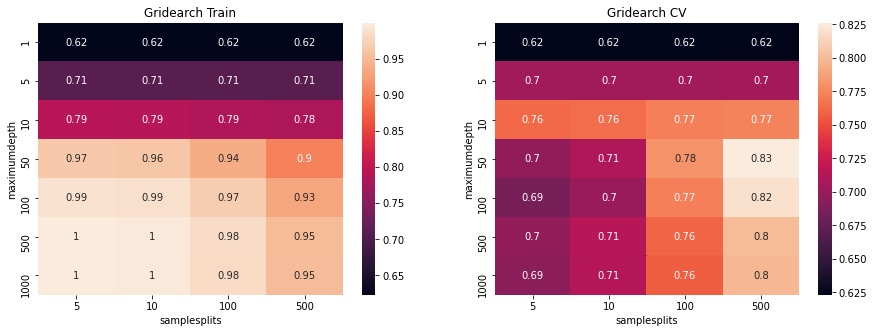

In [ ]:

clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,4)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,4)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=samplesplits,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_ylabel("maximumdepth")
  axes[i].set_xlabel("samplesplits")


plt.show()

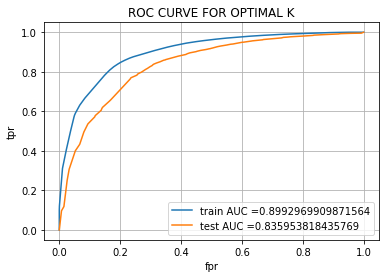

Area under train roc 0.8992969909871564
Area under test roc 0.835953818435769


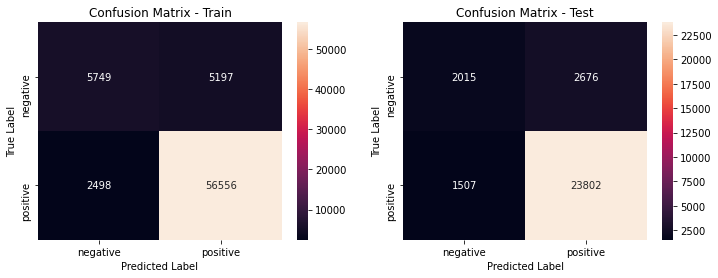

In [ ]:

best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_tr,X_test_bow,y_test)

# Decision Trees On TFIDF Features

Model with best parameters :
 {'max_depth': 50, 'min_samples_split': 500}


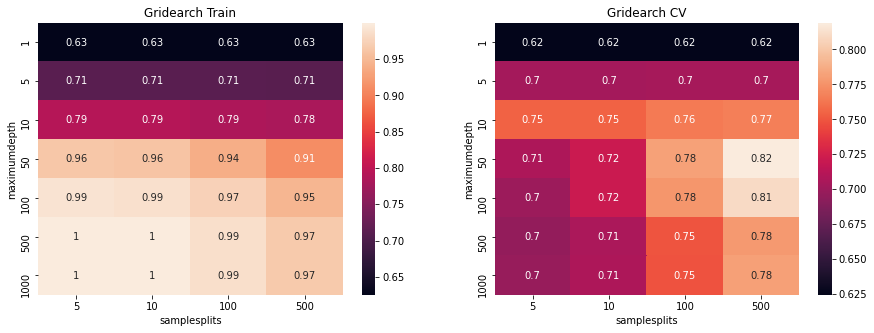

In [ ]:
clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,4)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,4)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=samplesplits,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_ylabel("maximumdepth")
  axes[i].set_xlabel("samplesplits")


plt.show()

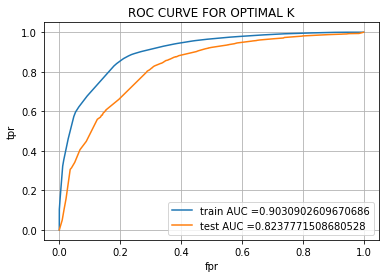

Area under train roc 0.9030902609670686
Area under test roc 0.8237771508680528


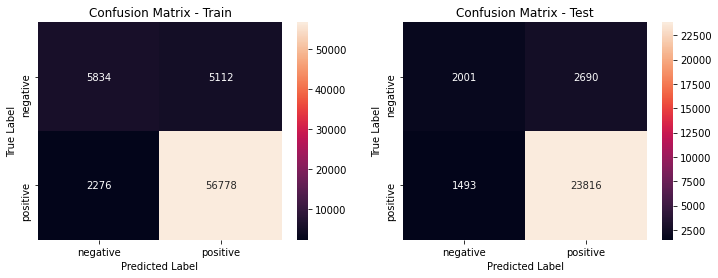

In [ ]:

best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_tr,X_test_tfidf,y_test)

# Decision Tree On AvgWord2Vec Features

Model with best parameters :
 {'max_depth': 10, 'min_samples_split': 500}


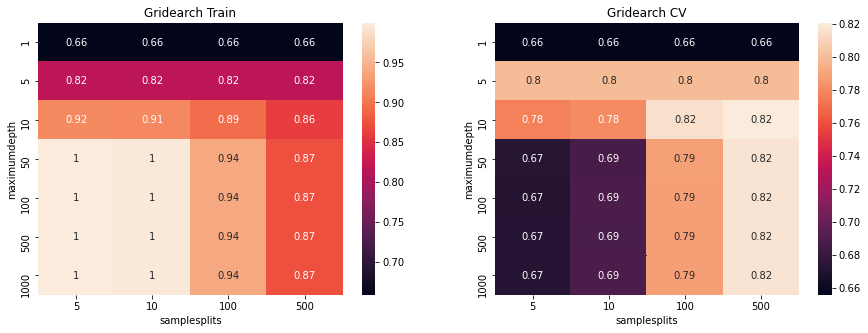

In [ ]:
clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,4)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,4)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=samplesplits,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_ylabel("maximumdepth")
  axes[i].set_xlabel("samplesplits")


plt.show()

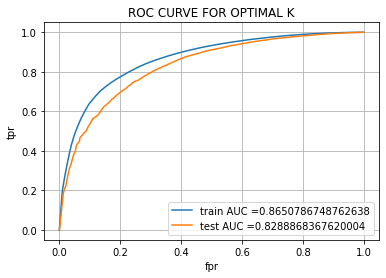

Area under train roc 0.8650786748762638
Area under test roc 0.8288868367620004


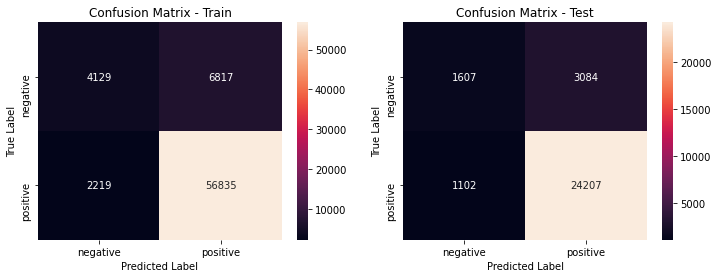

In [ ]:

best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


plot_confusion_matrixes(best_est,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

# Decision Tree On TFIDF Word2Vec Features

Model with best parameters :
 {'max_depth': 10, 'min_samples_split': 500}


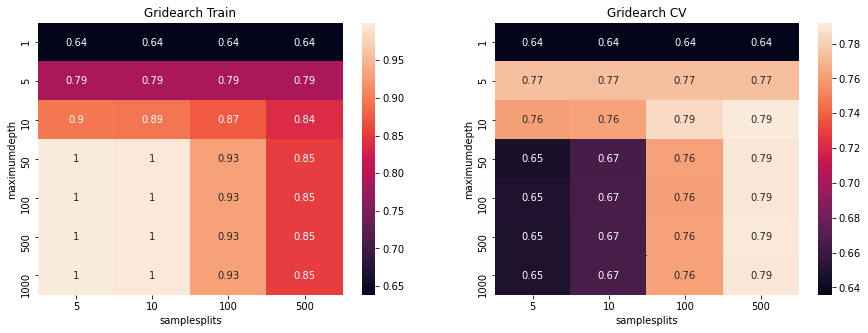

In [ ]:
clf = DecisionTreeClassifier()
samplesplits = [5, 10, 100, 500]
maximumdepth = [1, 5, 10, 50, 100, 500, 1000]
parameters = {'min_samples_split':samplesplits ,'max_depth':maximumdepth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(7,4)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,4)

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=samplesplits,yticklabels=maximumdepth,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_ylabel("maximumdepth")
  axes[i].set_xlabel("samplesplits")


plt.show()

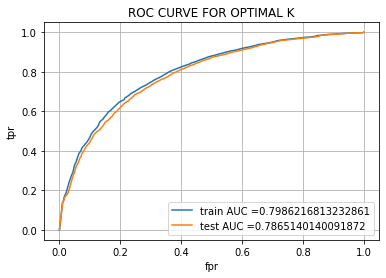

Area under train roc 0.7986216813232861
Area under test roc 0.7865140140091872


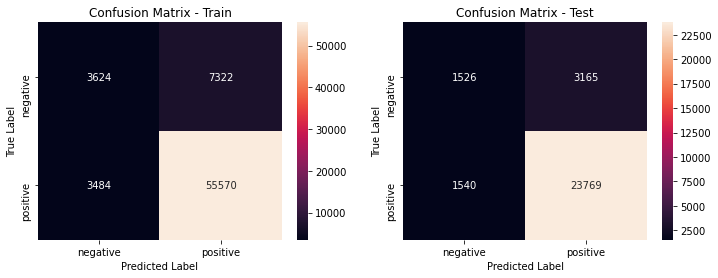

In [ ]:

best_est = DecisionTreeClassifier(**model.best_params_)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


plot_confusion_matrixes(best_est,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)

## Observations and Conclusions

In [1]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","Hyperparam-min_sample_splits","Hyperparam-max_Depth","Train AUC", "Test AUC"]
z.add_row(["bow","decision_tree",500,50, 0.8992969909871564,0.835953818435769])
z.add_row(["tfidf","decision_tree",500,50,0.9030902609670686, 0.8237771508680528 ])
z.add_row(["avgw2v","decision_tree",500,10, 0.8650786748762638,0.8288868367620004])
z.add_row(["tfidfw2v","decision_tree",500,10,0.7986216813232861,0.7865140140091872])
print(z)



+----------+---------------+------------------------------+----------------------+--------------------+--------------------+
|  Vector  |   Algorithm   | Hyperparam-min_sample_splits | Hyperparam-max_Depth |     Train AUC      |      Test AUC      |
+----------+---------------+------------------------------+----------------------+--------------------+--------------------+
|   bow    | decision_tree |             500              |          50          | 0.8992969909871564 | 0.835953818435769  |
|  tfidf   | decision_tree |             500              |          50          | 0.9030902609670686 | 0.8237771508680528 |
|  avgw2v  | decision_tree |             500              |          10          | 0.8650786748762638 | 0.8288868367620004 |
| tfidfw2v | decision_tree |             500              |          10          | 0.7986216813232861 | 0.7865140140091872 |
+----------+---------------+------------------------------+----------------------+--------------------+--------------------+


* Performance of decision trees are lower compared to logistic regression,naive bayes and SVM.
* We can get better results by using ensembeling techniques like bagging and boosting on decision trees.
* We could also try post-pruning methods such as cost complexity pruning which helps to avoid overfitting. Since we are using random forest next,we are not trying that.
